In [1]:
%%capture
!pip install fastai
!pip install timm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
from pathlib import Path

import timm
from fastai.vision.all import *

In [4]:
class config:
    BASE_DIR = Path('/content/drive/MyDrive/work_projects/LP')
    DATA_DIR = BASE_DIR / 'data'
    MODEL_DIR = BASE_DIR / 'models'

In [5]:
with zipfile.ZipFile(config.DATA_DIR / 'archive_3.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [6]:
chars = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, do_flip=False))

In [7]:
dls = chars.dataloaders('/content/dataset', bs=64)

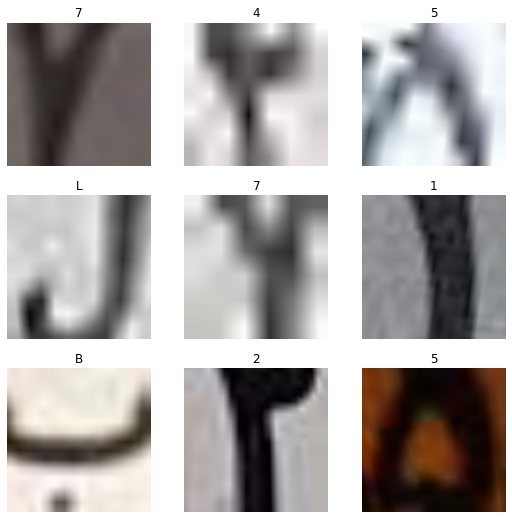

In [8]:
dls.show_batch()

In [9]:
pretrained_swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(dls.vocab))

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224.pth


In [10]:
f1_macro = F1Score(average='macro')
f1_macro.name = 'F1(macro)'
cbs = SaveModelCallback(monitor='accuracy')
learn = Learner(dls, pretrained_swin, metrics=[accuracy, f1_macro], cbs=cbs, loss_func=CrossEntropyLossFlat())

SuggestedLRs(valley=3.630780702224001e-05)

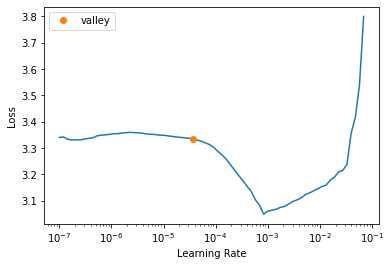

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(4, 2e-4)

epoch,train_loss,valid_loss,accuracy,F1(macro),time
0,0.216225,0.105166,0.966543,0.971339,15:39
1,0.119452,0.048642,0.983898,0.986345,15:38
2,0.066334,0.026631,0.992247,0.993589,15:37
3,0.048431,0.023184,0.993500,0.994747,15:36


Better model found at epoch 0 with accuracy value: 0.966543436050415.
Better model found at epoch 1 with accuracy value: 0.9838979244232178.
Better model found at epoch 2 with accuracy value: 0.9922471642494202.
Better model found at epoch 3 with accuracy value: 0.9934995174407959.


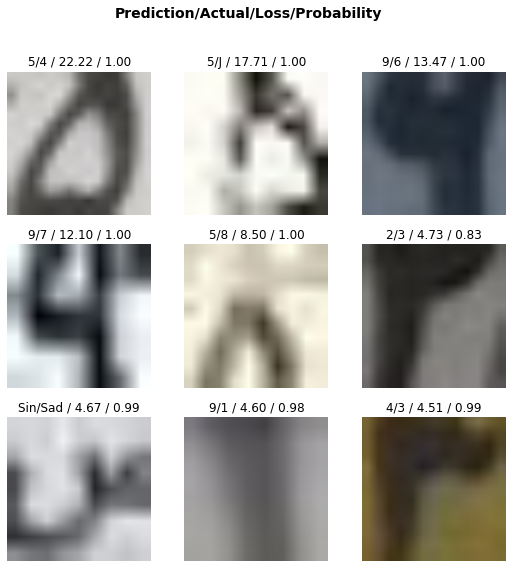

In [13]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

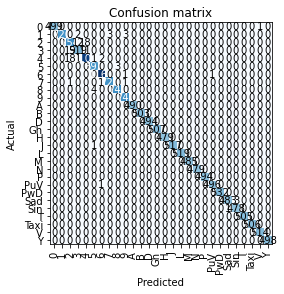

In [18]:
c_interp = ClassificationInterpretation.from_learner(learn)
c_interp.plot_confusion_matrix()

In [19]:
learn.export(config.MODEL_DIR / 'Char_detector_swin.pkl')